# Evaluate trained model and fine-tune inference
__Note:__ For this tutorial to work, you first need to download some data and example models (266MB) from [here](https://www.dropbox.com/sh/wnj3389k8ei8i1c/AACy7apWxW87IS_fBjI8-7WDa?dl=0) and put the four folders in the `tutorials` folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dss.utils, dss.utils_plot, dss.predict, dss.event_utils

/Users/janc/miniconda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/janc/miniconda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


`save_name` should be the stem common to all files produced during training.
For instance, if the parameter file for the model is `res/20191121_094529_params.yaml`, then `save_name` should be `res/20191121_094529`.

The tutorials come with two networks to for Dmel pulse song:
- `models/dmel_pulse_tcn_single_channel/` is an optimal model for dmel single-channel pulse song
- `res/20191128_170521` is a smaller TCN model  trained for 20 epochs on the toy data set produced by [1_prepare_data.ipynb](1_prepare_data.ipynb) and trained with the parameters in [2_training.ipynb](2_training.ipynb).

In [2]:
save_name = 'models/dmel_pulse_tcn_single_channel/'  # the best model for dmel single-channel pulse song
# save_name = 'res/20191128_170521'  # model trained for 20 epochs on the toy data set produced by data_gather.ipynb and trained with the parameters in training.ipynb

params = dss.utils.load_params(save_name)

print(params)
dwn_smp = 1
if 'cnn' in params['model_name']:
    y_offset = params['y_offset']
else:
    y_offset = params['data_padding']

fs = params['samplerate_y_Hz']


try: 
    segment_pred_index = params['class_types'][1:].index('segment') + 1
    print(f'model predicts segments at index {segment_pred_index}')
except ValueError:
    print('model does not predict segments.')
    segment_pred_index = None

   
try: 
    pulse_pred_index = params['class_types'].index('event')    
    print(f'model predicts pulses at index {pulse_pred_index}')

except ValueError:
    print('model does not predict pulse.')
    pulse_pred_index = None

print(fs, y_offset)

{'batch_norm': True, 'batch_size': 32, 'class_names': ['noise', 'pulse'], 'class_names_pulse': ['noise', 'pulse'], 'class_names_sine': ['noise', 'sine'], 'class_types': ['segment', 'event'], 'class_types_pulse': ['segment', 'event'], 'class_types_sine': ['segment', 'segment'], 'cut_trailing_dim': True, 'data_dir': '../dat/dmel_single_stern_raw.npy', 'data_padding': 32, 'dwnsmp': 1, 'eventtimes_units_Hz': 'seconds', 'fraction_data': 1.0, 'ignore_boundaries': True, 'keep_intermediates': False, 'kernel_size': 64, 'loss': 'categorical_crossentropy', 'model_name': 'tcn', 'nb_channels': 1, 'nb_classes': 2, 'nb_conv': 4, 'nb_filters': 32, 'nb_freq': 1, 'nb_hist': 4096, 'nb_stacks': 2, 'return_sequences': True, 'sample_weight_mode': 'temporal', 'samplerate_x_Hz': 10000, 'samplerate_y_Hz': 10000, 'save_dir': 'res.stern_raw/res.pulse', 'stride': 4032, 'with_y_hist': True, 'y_offset': 0, 'y_suffix': 'pulse'}
model does not predict segments.
model predicts pulses at index 1
10000 32


In [3]:
datasets = dss.utils.load_from(save_name + '_results.h5', ['x_test', 'y_test', 'y_pred'])
x_test, y_test, y_pred = [datasets[key] for key in ['x_test', 'y_test', 'y_pred']]  # unpack dict items to vars

labels_test = dss.predict.labels_from_probabilities(y_test)
labels_pred = dss.predict.labels_from_probabilities(y_pred)

/Users/janc/Dropbox/code.py/deepsongsegmenter/src/dss/event_utils.py:73: RuntimeWarning: invalid value encountered in greater
  nearest_event = np.ma.masked_array(nearest_event, mask=nearest_dist > tol)


FP 67, TP 1682, FN 93
precision 0.96, recall 0.95, f1-score 0.95
best threshold (max f1 score): 0.42


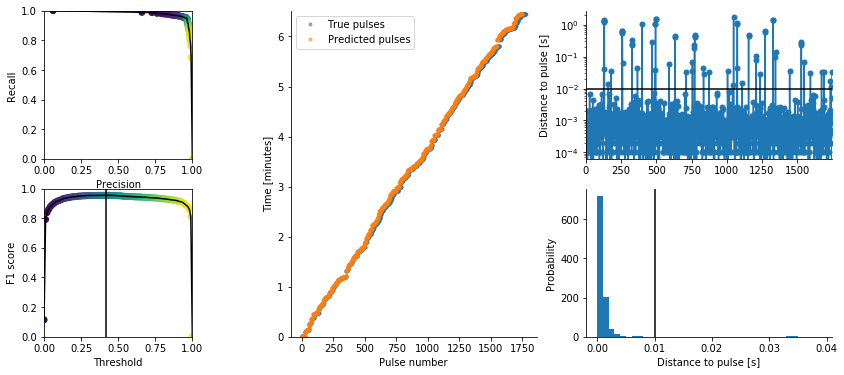

In [4]:
def prc_pulse(pred_pulse, pulsetimes_true, fs, tol, min_dist, dwn_smp=1, y_offset=0, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0, 1.01, 0.01)
    precision = []
    recall = []
    f1_score = []
    threshold = []

    for thres in thresholds:
        pulsetimes_pred, pulsetimes_pred_confidence = dss.event_utils.detect_events(pred_pulse, thres=thres, min_dist=min_dist)
        pulsetimes_pred = ((pulsetimes_pred * dwn_smp) + y_offset) / fs
        d, nn_pred_pulse, nn_true_pulse, nn_dist = dss.event_utils.evaluate_eventtimes(pulsetimes_true, pulsetimes_pred, fs, tol)
        precision.append(d['precision'])
        recall.append(d['recall'])
        f1_score.append(d['f1_score'])
        threshold.append(thres)
    return threshold, precision, recall, f1_score

# Evaluate events based on timing, allowing for some tolerance
tol = .01  # seconds = 10ms
min_dist = 0.01
    
if pulse_pred_index is not None:
    pulsetimes_true, _ = dss.event_utils.detect_events(y_test[:,1], thres=0.5, min_dist=100)
    pulsetimes_true =  pulsetimes_true / fs
    
    # calc f1 score for different thresholds and choose opt threshold
    threshold, precision, recall, f1_score = prc_pulse(y_pred[:,pulse_pred_index], pulsetimes_true, fs, tol, min_dist * fs)
    threshold_opt = threshold[np.argmax(f1_score)]
    
    # predict pulses using optimal threshold
    pulsetimes_pred, pulsetimes_pred_confidence = dss.event_utils.detect_events(y_pred[:,pulse_pred_index], thres=threshold_opt, min_dist=min_dist * fs)
    pulsetimes_pred = pulsetimes_pred / fs
    d, nn_pred_pulse, nn_true_pulse, nn_dist = dss.event_utils.evaluate_eventtimes(pulsetimes_true, pulsetimes_pred, fs, tol)
    
    print(f"FP {d['FP']}, TP {d['TP']}, FN {d['FN']}")
    print(f"precision {d['precision']:1.2f}, recall {d['recall']:1.2f}, f1-score {d['f1_score']:1.2f}")
    
    plt.gcf().set_size_inches(15, 6)
    plt.subplot(231)
    plt.plot(precision, recall, c='k')
    plt.scatter(precision, recall, c=threshold)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.subplot(234)
    plt.plot(threshold, f1_score, c='k')
    plt.scatter(threshold, f1_score, c=threshold)
    plt.axvline(threshold_opt, c='k')
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    print(f'best threshold (max f1 score): {threshold_opt:1.2f}')
    
    plt.subplot(132)
    plt.plot(pulsetimes_true / 60, '.', alpha=0.5)
    plt.plot(pulsetimes_pred / 60, '.', alpha=0.5)
    plt.legend(['True pulses', 'Predicted pulses'])
    plt.xlabel('Pulse number')
    plt.ylabel('Time [minutes]')
    plt.ylim(0, x_test.shape[0] / fs / 60 * 1.01 * dwn_smp)
    dss.utils_plot.remove_axes()

    plt.subplot(233)
    plt.plot(nn_dist, '.-', markersize=10)
    plt.xlim(0, len(nn_dist))
    plt.axhline(tol, color='k')
    plt.yscale('log')
    plt.ylabel('Distance to pulse [s]')
    dss.utils_plot.remove_axes()

    plt.subplot(236)
    plt.hist(nn_dist, bins=np.arange(0, 4 * tol, .001), density=True)
    plt.axvline(tol, color='k')
    plt.xlabel('Distance to pulse [s]')
    plt.ylabel('Probability');
    dss.utils_plot.remove_axes()

# Troubleshooting
Things to do when the predictions look weird:
- Plot the raw predictions alongside the input song recording, the labels used for training, and the raw event times. This will reveal whether there is an offset or even a mismatch in sampling frequencies.
- Plot at the shape of false negative and false positive pulses and look for patterns. Maybe there are weird shapes in the false negatives or many "good looking" pulses in the false negatives, indicating problems with the groundtruth (manual annotation).
- Inspect the amplitude and frequency of false negative and false positive pulses and look for patterns. Maybe the network fails for soft pulses

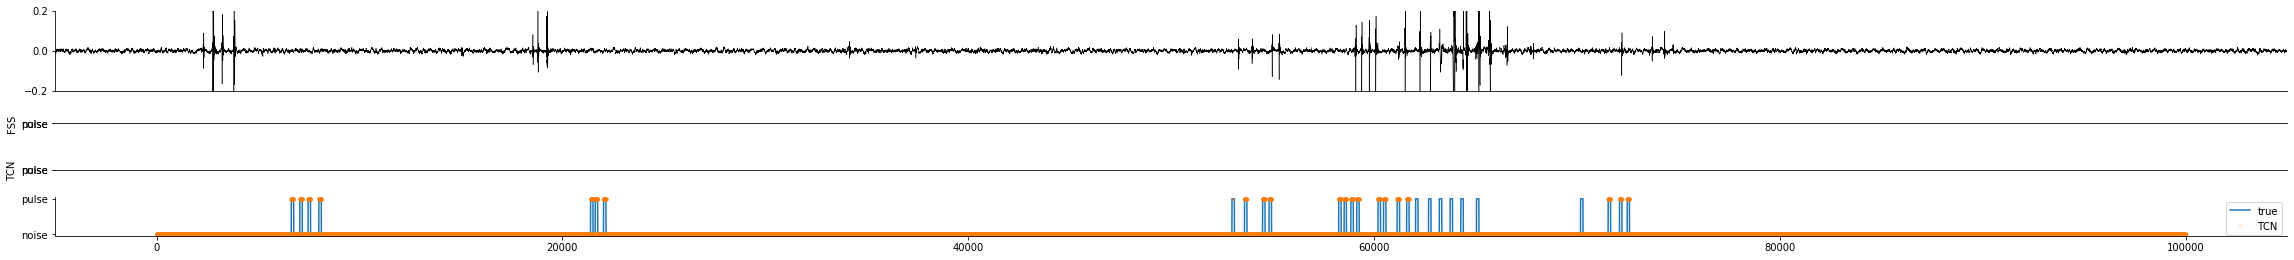

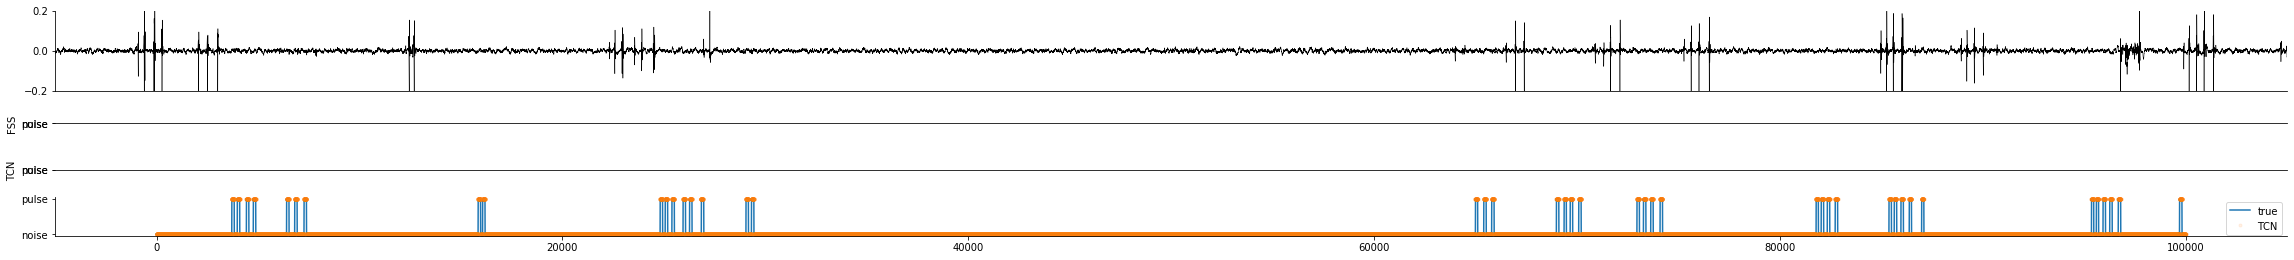

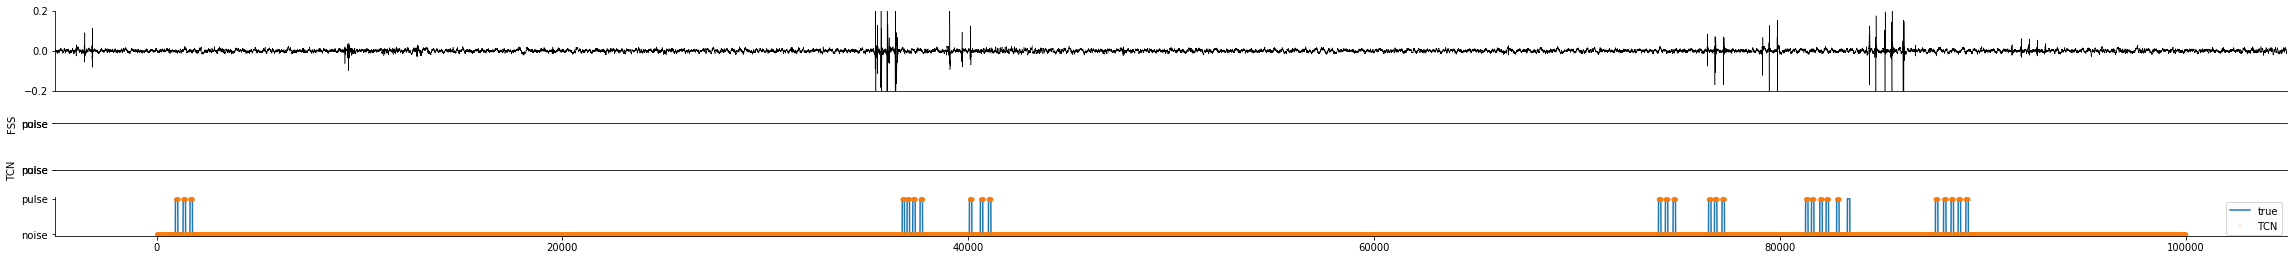

In [5]:
# Plot the raw predictions
# TODO: plot event times
for t0 in [160_000, int(1_270_000), int(1_430_000)]:
    t1 = int(t0 + 100_000)
    t0d = int(t0/dwn_smp)
    t1d = int(t1/dwn_smp)
    plt.figure()
    plt.gcf().set_size_inches(40,5)
    plt.subplot(311)
    plt.plot(x_test[y_offset + t0:y_offset+t1], c='k', linewidth=0.5)
    plt.xlim(0, (t1-t0))
    plt.ylim(-0.2, 0.2)
    plt.xticks([])
    dss.utils_plot.remove_axes()

    plt.subplot(613)
    plt.imshow(y_test[t0d:t1d].T, cmap='Blues')
    plt.yticks((0, 1), labels=params['class_names'])
    plt.ylabel('FSS')
    plt.xticks([])
    dss.utils_plot.remove_axes()

    plt.subplot(614)
    plt.imshow(y_pred[t0d:t1d].T, cmap='Oranges')
    plt.yticks((0, 1), labels=params['class_names'])
    plt.ylabel('TCN')
    plt.xticks([])
    dss.utils_plot.remove_axes()
    
    plt.subplot(615)
    plt.plot(labels_test[t0d:t1d])
    plt.plot(labels_pred[t0d:t1d], '.', alpha=0.1)
    plt.yticks((0, 1), labels=params['class_names'])
    
    plt.legend(('true', 'TCN'))
    dss.utils_plot.remove_axes()

/Users/janc/Dropbox/code.py/deepsongsegmenter/src/dss/pulse_utils.py:37: RuntimeWarning: invalid value encountered in true_divide
  y /= np.max(y)
/Users/janc/Dropbox/code.py/deepsongsegmenter/src/dss/pulse_utils.py:39: RuntimeWarning: invalid value encountered in less
  y[y < 0] = 0
/Users/janc/Dropbox/code.py/deepsongsegmenter/src/dss/pulse_utils.py:22: RuntimeWarning: invalid value encountered in true_divide
  pulse /= np.linalg.norm(pulse)


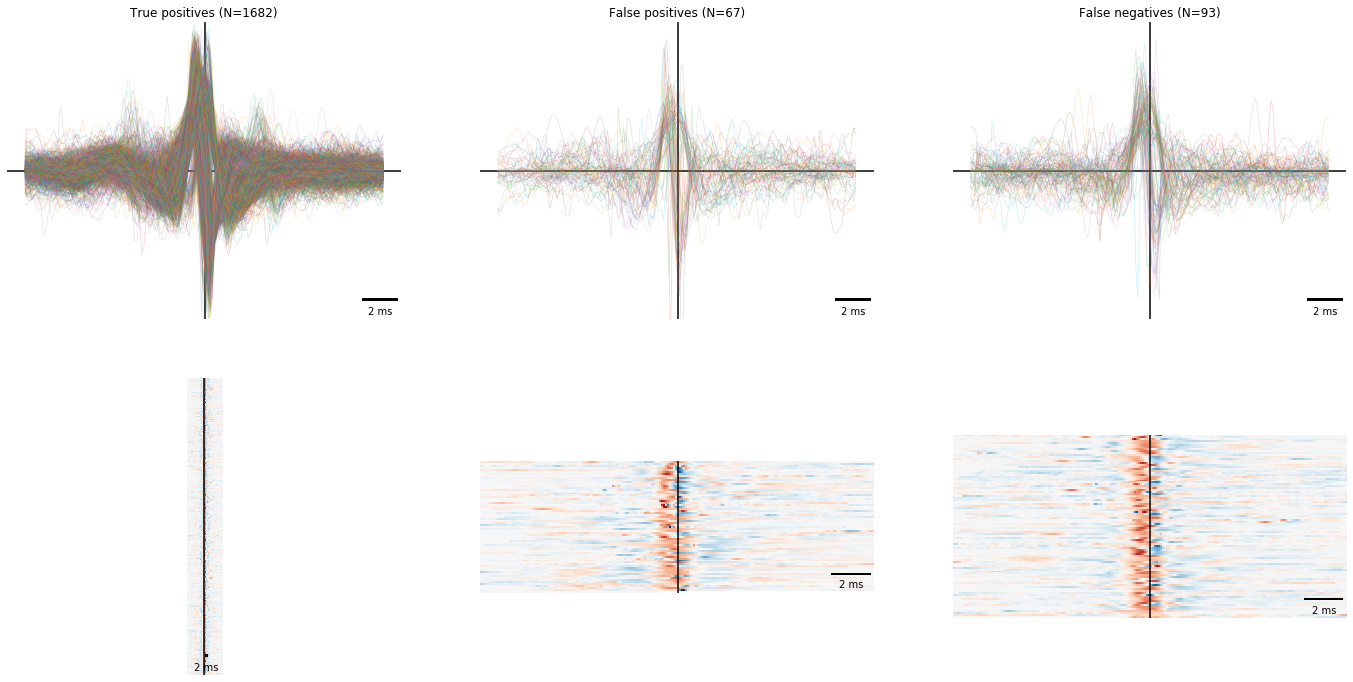

In [6]:
# Plot the shapes of false/true positive/negative pulses - if you use the network trained on the toy data set, most false positives arise from wrong annotations
import dss.pulse_utils
def plot_pulses(pulseshapes, col=1, title=''):
    win_hw = pulseshapes.shape[0]/2
    plt.subplot(2, 3, col)
    plt.axvline(win_hw, color='k')
    plt.axhline(0, color='k')
    plt.plot(pulseshapes, linewidth=0.75, alpha=0.2)
    plt.ylim(-0.5, 0.5)
    plt.title(title)
    dss.utils_plot.scalebar(2, units='ms', dx=0.1)
    dss.utils_plot.remove_axes(all=True)
    
    plt.subplot(2, 3, col+3)
    plt.imshow(pulseshapes.T, cmap='RdBu_r')
    plt.clim(-0.5, 0.5)
    plt.axvline(win_hw, color='k')
    dss.utils_plot.scalebar(2, units='ms', dx=0.1)
    dss.utils_plot.remove_axes(all=True)

win_hw = 100
if pulse_pred_index is not None:
    pulseshapes_pred = dss.pulse_utils.get_pulseshapes(pulsetimes_pred * fs + win_hw, x_test, win_hw)
    pulsenorm_pred = np.linalg.norm(np.abs(pulseshapes_pred[50:-50,:]), axis=0)
    pulsefreq_pred = np.array([dss.pulse_utils.pulse_freq(p)[0] for p in pulseshapes_pred[50:-50,:].T])
    pulseshapes_pred = np.apply_along_axis(dss.pulse_utils.normalize_pulse, axis=-1, arr=pulseshapes_pred.T).T
    tp_pulses = pulseshapes_pred[:, ~nn_pred_pulse.mask]
    fp_pulses = pulseshapes_pred[:, nn_pred_pulse.mask]

    pulseshapes_true = dss.pulse_utils.get_pulseshapes(pulsetimes_true * fs + win_hw, x_test, win_hw)
    pulsenorm_true = np.linalg.norm(np.abs(pulseshapes_true[50:-50,:]), axis=0)
    pulsefreq_true = np.array([dss.pulse_utils.pulse_freq(p)[0] for p in pulseshapes_true[50:-50,:].T])
    pulseshapes_true = np.apply_along_axis(dss.pulse_utils.normalize_pulse, axis=-1, arr=pulseshapes_true.T).T

    fn_pulses = pulseshapes_true[:, nn_true_pulse.mask]

    plt.gcf().set_size_inches(24,12)
    plot_pulses(tp_pulses, 1, f'True positives (N={tp_pulses.shape[1]})')
    plot_pulses(fp_pulses, 2, f'False positives (N={fp_pulses.shape[1]})')
    plot_pulses(fn_pulses, 3, f'False negatives (N={fn_pulses.shape[1]})')

/Users/janc/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/Users/janc/miniconda/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/janc/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


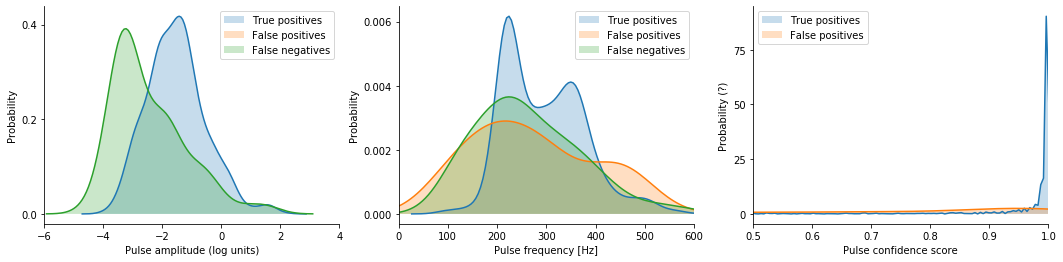

In [7]:
# Check the amplitude and frequency of pulses as well as the pulse confidence scores
if pulse_pred_index is not None:
    plt.gcf().set_size_inches(18,4)
    plt.subplot(131)
    sns.kdeplot(np.log2(pulsenorm_pred[~nn_pred_pulse.mask]), shade=True, clip=(-6, 4));
    sns.kdeplot(np.log2(pulsenorm_pred[nn_pred_pulse.mask]), shade=True, clip=(-6, 4));
    sns.kdeplot(np.log2(pulsenorm_true[nn_true_pulse.mask]), shade=True, clip=(-6, 4));
    plt.legend(['True positives', 'False positives', 'False negatives'])
    plt.xlim(-6, 4)
    plt.xlabel('Pulse amplitude (log units)')
    plt.ylabel('Probability')
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=6)
    dss.utils_plot.remove_axes()
    
    plt.subplot(132)
    sns.kdeplot(pulsefreq_pred[~nn_pred_pulse.mask], shade=True, clip=(0, 600));
    sns.kdeplot(pulsefreq_pred[nn_pred_pulse.mask], shade=True, clip=(0, 600));
    sns.kdeplot(pulsefreq_true[nn_true_pulse.mask], shade=True, clip=(0, 600));
    plt.legend(['True positives', 'False positives', 'False negatives'])
    plt.xlim(0, 600)
    plt.xlabel('Pulse frequency [Hz]')
    plt.ylabel('Probability')
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=6)
    dss.utils_plot.remove_axes()

    plt.subplot(133)
    sns.kdeplot(pulsetimes_pred_confidence[~nn_pred_pulse.mask], shade=True, clip=(0, 1))
    sns.kdeplot(pulsetimes_pred_confidence[nn_pred_pulse.mask], shade=True, clip=(0, 1))
    plt.axis('tight')
    plt.xlim(0.5, 1)
    plt.legend(['True positives', 'False positives'], loc='upper left')
    plt.xlabel('Pulse confidence score')
    plt.ylabel('Probability (?)')
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=8)
    dss.utils_plot.remove_axes()


### 